In [1]:
from robo_trader import Trader
from robo_trader.feeds import YFinanceFeed
import pandas_ta as pta
from robo_trader.strategy import Strategy
from robo_trader.portfolio import Portfolio
import ta
import pandas as pd

In [2]:
class StRsiStrategy(Strategy):
    def __init__(self):
        super().__init__()

    def evaluate_market(self, symbol: str, prices: pd.DataFrame, portfolio: Portfolio):
        data = prices.copy()
        
        supertrend_data = pta.supertrend(data['high'], data['low'], data['close'], length=12, multiplier=3)
        data['supertrend'] = supertrend_data['SUPERT_12_3.0']

        # Calculate RSI
        data['rsi'] = pta.rsi(data['close'], length=6)

        # Define Supertrend trend direction for entry and exit
        data['supertrend_signal'] = (data['supertrend'] < data['close'])

        # Define RSI signal (oversold condition)
        rsi_oversold = 30  # Adjust this threshold as needed
        data['rsi_signal'] = data['rsi'] < rsi_oversold

        # Combine signals
        data['long_entry'] = data['supertrend_signal'] & data['rsi_signal']
        
        # Get the last price point
        last_price_point = data.iloc[-1]
        
        # Check for entry signal
        if last_price_point['long_entry']:
            #portfolio.open_long(symbol, .25, take_profit_percentage=.025, stop_percentage=.01)
            portfolio.open_long(symbol, 1, trail_percentage=.01, take_profit_percentage=.05)
        # No need to implement exit logic as we're using trailing stop loss


In [3]:
class MacdCciStrategy(Strategy):
    def __init__(self):
        super().__init__()

    def evaluate_market(self, symbol: str, prices: pd.DataFrame, portfolio: Portfolio):
        data = prices.copy()
        
        # Calculate MACD
        macd = pta.macd(data['close'])
        data['macd'] = macd['MACD_12_26_9']
        data['signal'] = macd['MACDs_12_26_9']
        data['macd_hist'] = macd['MACDh_12_26_9']

        # Calculate CCI
        data['cci'] = pta.cci(data['high'], data['low'], data['close'], length=20)

        # Define MACD signal for entry
        data['macd_signal'] = (data['macd'] > data['signal']) & (data['macd_hist'] > 0)

        # Define CCI signal (oversold condition)
        cci_oversold = -40  # Adjust this threshold as needed
        data['cci_signal'] = data['cci'] < cci_oversold

        # Combine signals
        data['long_entry'] = data['macd_signal'] & data['cci_signal']
        
        # Get the last price point
        last_price_point = data.iloc[-1]
        
        # Check for entry signal
        if last_price_point['long_entry']:
            portfolio.open_long(symbol, 1, trail_percentage=0.05)


In [4]:
# SYMBOL = "BTC-GBP"
# train_since = datetime(2016, 7, 1, tzinfo=timezone.utc)
# start_date = datetime(2018, 7, 1, tzinfo=timezone.utc)
# end_date = datetime(2019, 7, 1, tzinfo=timezone.utc)
# interval = Interval.ONE_DAY
# period = 28

SYMBOL = "BTC-GBP"
#SYMBOL = "AAPL"
train_since = pd.to_datetime('2023-12-24').tz_localize('UTC')
start_date = pd.to_datetime('2024-01-01').tz_localize('UTC')
end_date = pd.to_datetime('2024-07-01').tz_localize('UTC')
period = 168

feed = YFinanceFeed(interval = '1h')
strategy = StRsiStrategy()
#strategy = MacdCciStrategy()
trader = Trader(SYMBOL, 1000, feed, strategy)

In [5]:
# Run the backtest
portfolio = trader.backtest(start_date, end_date, period, train_since, transaction_cost=0.004, trailing_stop_penalty_relief=0.9)

Request to open long position on BTC-GBP
    Opening long position for BTC-GBP with for 100% of the cash (£1000)
    Creating MARKET BUY order for BTC-GBP at 34218.64453125 with quantity 0.02910693902823673, trail None, limit None, stop None, take_profit None
    Executing MARKET BUY order for BTC-GBP at 34218.64453125 with quantity 0.02910693902823673, total cost £999.984 and transaction cost £3.984
        Bought 0.02910693902823673 BTC-GBP at 34218.64453125 on 05/01/2024 01:00
    Creating TRAILING_STOP SELL order for BTC-GBP at 34218.64453125 with quantity 0.02910693902823673, trail 0.01, limit None, stop None, take_profit None
    Updated trailing stop to 33984.2862109375
    Updated trailing stop to 34057.2041796875
    Creating TRAILING_STOP SELL order for BTC-GBP at 34399.390625 with quantity 0.02910693902823673, trail 0.004987390344696268, limit None, stop None, take_profit None
Updated trailing stop for BTC-GBP to 34227.83 (trail: 0.50%)
    Updated trailing stop to 34289.964

Win Rate: 0.43
Initial Value: 1000.00
Final Value: 1010.46
Portfolio Return: 0.0105
Asset Return: 0.4858


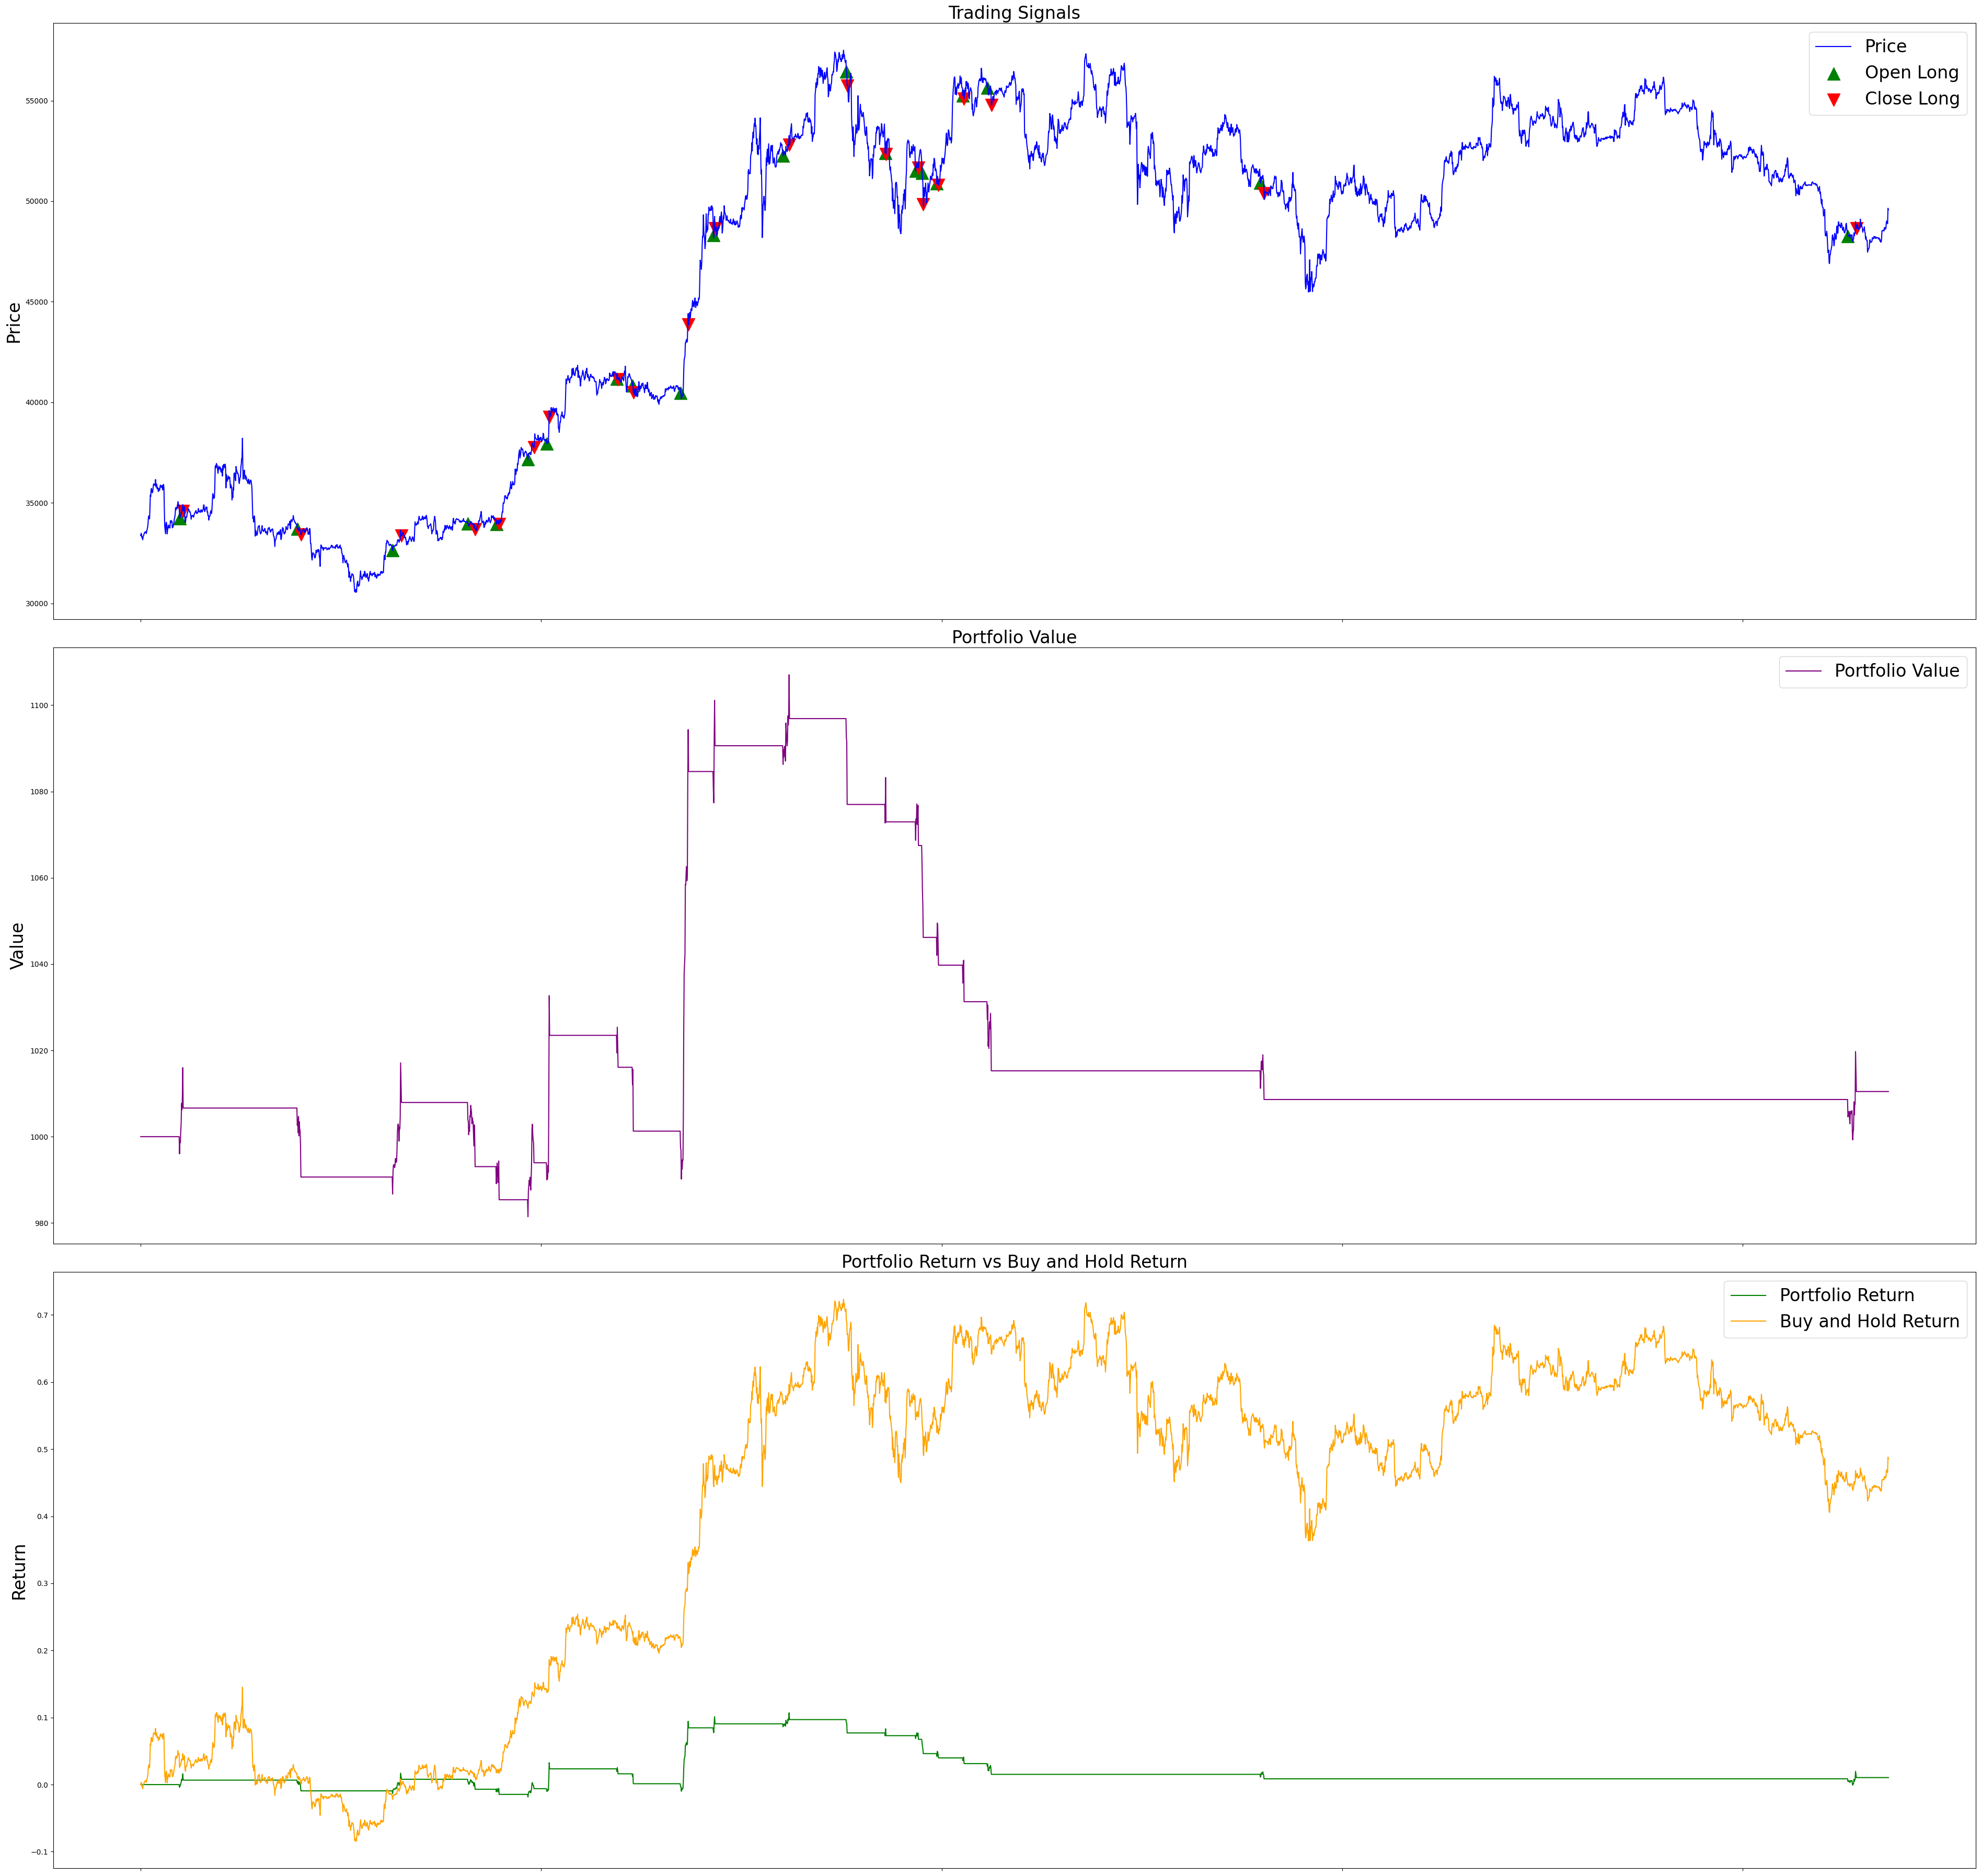

In [6]:
portfolio.plot_performance()